In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import*

In [4]:
! {sys.executable} -m pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.4)


In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kangcshin","key":"4c9496eeaeb0df00ade88cb50eb83009"}'}

In [0]:
ls

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/


In [13]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [22]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}


 99% 595M/600M [00:10<00:00, 33.7MB/s]
100% 600M/600M [00:10<00:00, 61.6MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 63.4MB/s]


In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}


In [24]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))


In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

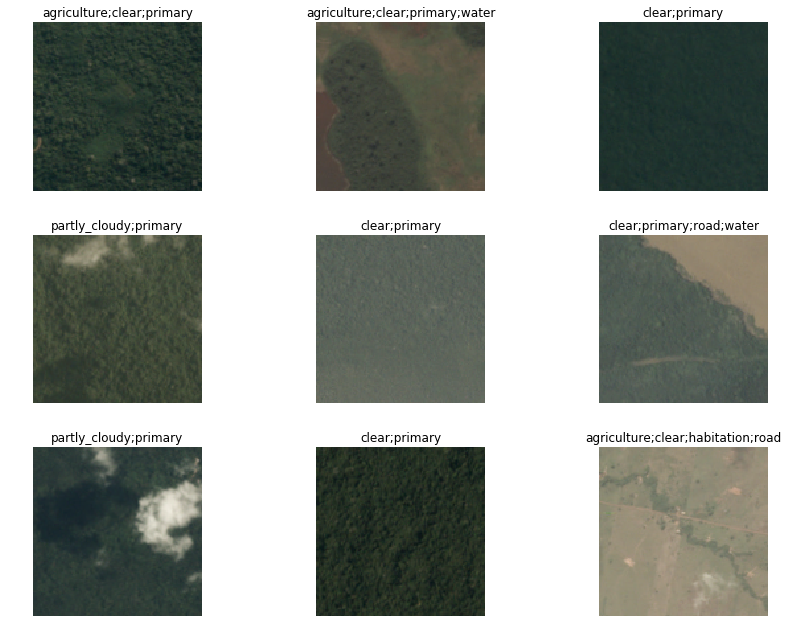

In [28]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet50

In [30]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 37739923.47it/s]


In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


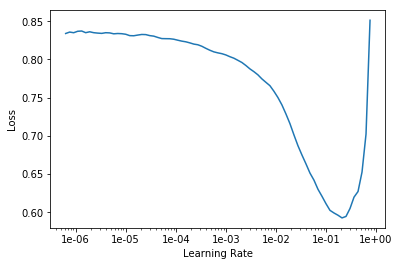

In [32]:
learn.recorder.plot()

In [0]:
lr = 0.01

In [34]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.127859,0.108932,0.942572,0.904197,02:40
1,0.112742,0.096893,0.948494,0.915338,02:41
2,0.100831,0.092254,0.954198,0.920447,02:41
3,0.096766,0.088529,0.956734,0.924479,02:41
4,0.091547,0.087290,0.957068,0.924698,02:40


In [0]:
learn.save('stage-1-rn50')

### Change parameters from here

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


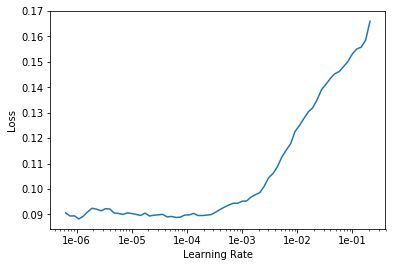

In [37]:
learn.lr_find()
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097496,0.089938,0.956415,0.924780,02:47
1,0.098513,0.090710,0.954475,0.922129,02:49
2,0.088784,0.084974,0.958573,0.926379,02:49
3,0.084119,0.082855,0.958355,0.928292,02:49
4,0.081051,0.082591,0.958580,0.928826,02:49


In [0]:
learn.save('stage-2-rn50')

In [40]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


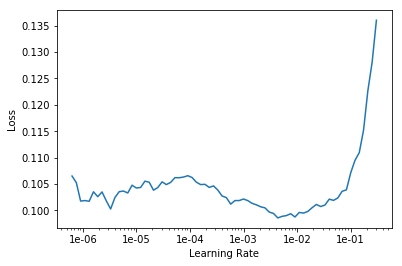

In [42]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [44]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086213,0.084077,0.957926,0.928445,05:21
1,0.086182,0.084303,0.960063,0.927570,05:22
2,0.084383,0.082608,0.956734,0.927657,05:23
3,0.081186,0.081313,0.958754,0.929222,05:24
4,0.079234,0.081095,0.959859,0.930239,05:20


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [47]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084821,0.084486,0.957468,0.925639,06:57
1,0.086863,0.083117,0.956524,0.928487,06:56
2,0.081581,0.082542,0.959031,0.930015,06:57
3,0.078925,0.080955,0.959052,0.929791,06:56
4,0.076273,0.080838,0.960259,0.930493,06:56


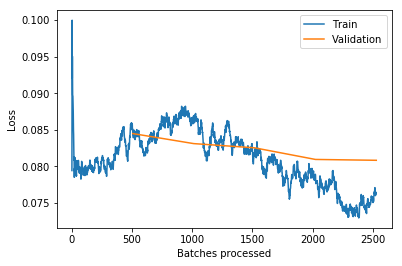

In [48]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

In [0]:
learn.export()